# Visualizations of MarI/O output

*Marius Milner, 2/2017*

This notebook lets you mine information from the console logs of SethBling's MarI/O program ([video](https://www.youtube.com/watch?v=qv6UVOQ0F44
), [source code](http://pastebin.com/ZZmSNaHX)). The code below inspects the logs for fitness values. The fitness value, by default, is a measure of progress toward efficient level completion:
> *fitness = (x-coordinate of player) - (frame count) / 4*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set default plot parameters
plt.rcParams["figure.figsize"] = [14, 10]

all_gen = []
all_species = []
all_genome = []
all_fitness = []
# Read raw log text into the lists above
# Change the file name below to switch between different log files.
for raw_line in open('mar_io_run0_128.txt'):
    raw_line = raw_line.strip().split()
    if raw_line and not raw_line[0].startswith('#') and len(raw_line) == 8:
        _, raw_gen, _, raw_species, _, raw_genome, _, raw_fitness = raw_line
        all_gen.append(int(raw_gen))
        all_species.append(int(raw_species))
        all_genome.append(int(raw_genome))
        all_fitness.append(float(raw_fitness))
num_generations = len(set(all_gen))
# Load the lists into a dataframe
df = pd.DataFrame(data={
    'gen': all_gen,
    'species': all_species,
    'genome': all_genome,
    'fitness': all_fitness,
})

# Group generations into buckets of size gen_step
gen_step = 8
gen_ranges = [(i, i + gen_step) for i in range(0, max(all_gen), gen_step)]
gen_labels = ['{}-{}'.format(i, j-1) for i, j in gen_ranges]
gen_queries = ['gen >= {0} and gen < {1} and fitness >= 0'.format(i, j)
               for i, j in gen_ranges]
# Query fitness values for each generation bucket in turn
fitnesses_by_gen_range = [df.query(q)['fitness'] for q in gen_queries]

# Get a quick summary of what we loaded
df.describe()

,fitness,gen,genome,species
count,34216.000000,34216.000000,34216.000000,34216.000000
mean,607.557692,66.481441,9.735095,18.254735
std,483.520275,36.179351,8.022282,27.112568
min,-4641.500000,0.000000,1.000000,1.000000
25%,212.000000,36.000000,4.000000,5.000000
50%,449.000000,67.000000,7.000000,10.000000
75%,1022.500000,98.000000,13.000000,19.000000
max,1935.000000,127.000000,65.000000,300.000000


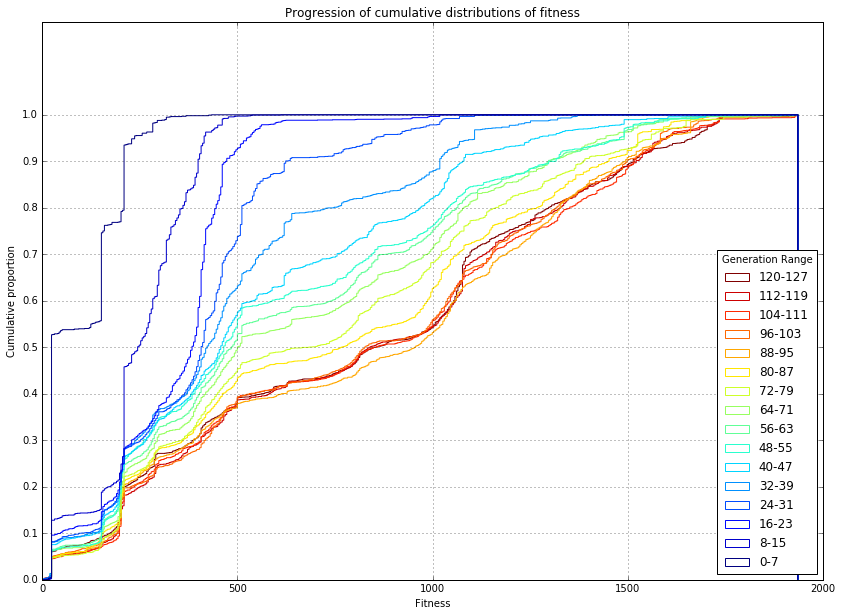

In [2]:
# Plot observed CDF for each generation bucket
fig, ax = plt.subplots()

_, _, patches = ax.hist(
    fitnesses_by_gen_range,
    500,  # Number of histogram buckets
    cumulative=True,  # Cumulative
    histtype='step',
    label=gen_labels,
    normed=True,  # Plot distribution rather than count
)

# Remap all the colors since the default just cycles through a list of seven colors
col_step = 1. / (len(patches) - 1)
col = np.arange(0., 1. + col_step, col_step)  # scale values to interval [0,1]
cm = plt.cm.get_cmap('jet')
for c, p in zip(col, patches):
    plt.setp(p, 'color', cm(c))

ax.legend(title='Generation Range', loc='lower right')
ax.set_title('Progression of cumulative distributions of fitness')
ax.set_xlabel('Fitness')
ax.set_ylabel('Cumulative proportion')
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

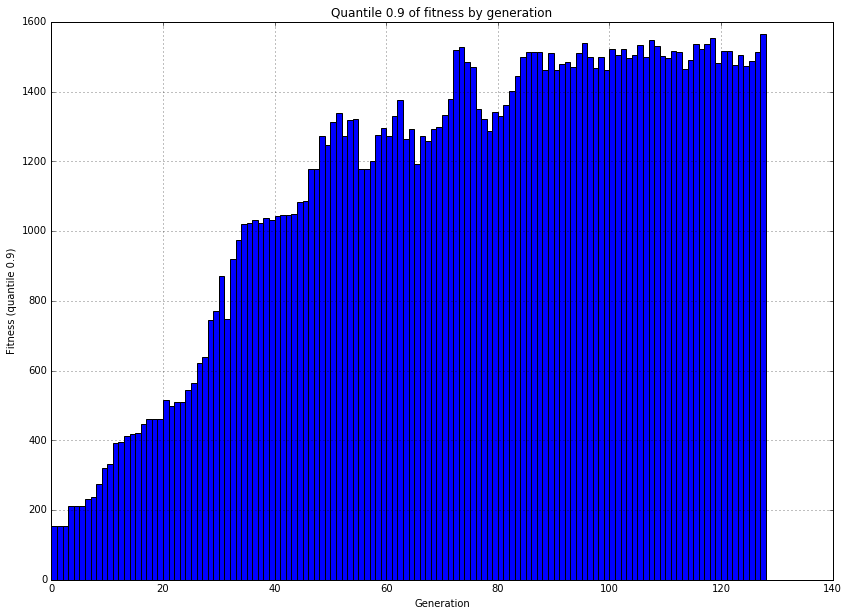

In [3]:
# Percentile by generation
fig, ax = plt.subplots()

quantile = 0.9

ax.bar(
    np.arange(num_generations),  # bar left
    [
        df.query('gen == {}'.format(gen))['fitness'].quantile(quantile) 
        for gen in range(num_generations)
    ],  # bar height
    1,  # bar width
)

ax.set_title('Quantile {} of fitness by generation'.format(quantile))
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness (quantile {})'.format(quantile))
plt.grid()
plt.show()

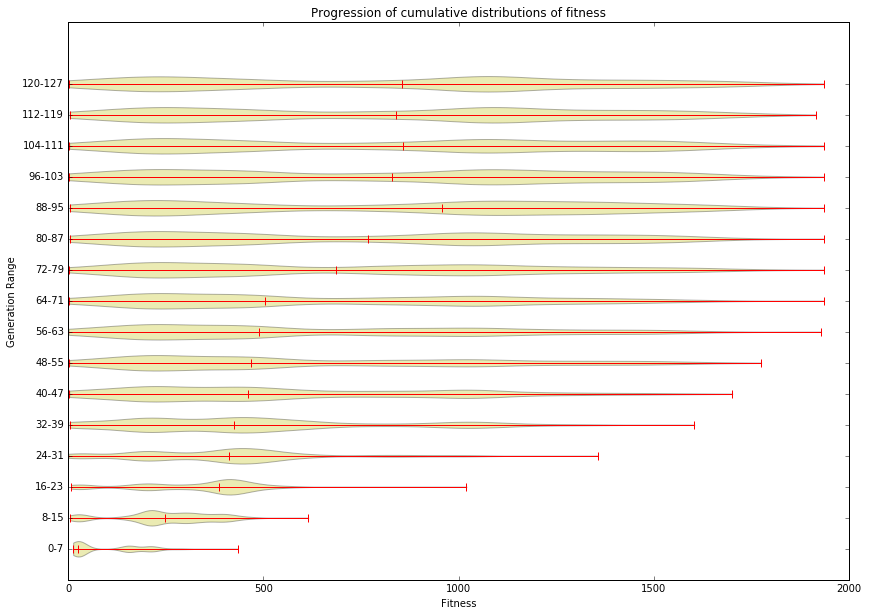

In [4]:
# Same information as above, but use a violin plot
fig, ax = plt.subplots()
ax.violinplot(fitnesses_by_gen_range, showmedians=True, vert=False)
ax.set_title('Progression of cumulative distributions of fitness')
ax.set_xlabel('Fitness')
ax.set_ylabel('Generation Range')
ax.set_yticks([1 + i for i in range(len(gen_labels))])
ax.set_yticklabels(gen_labels)
plt.show()

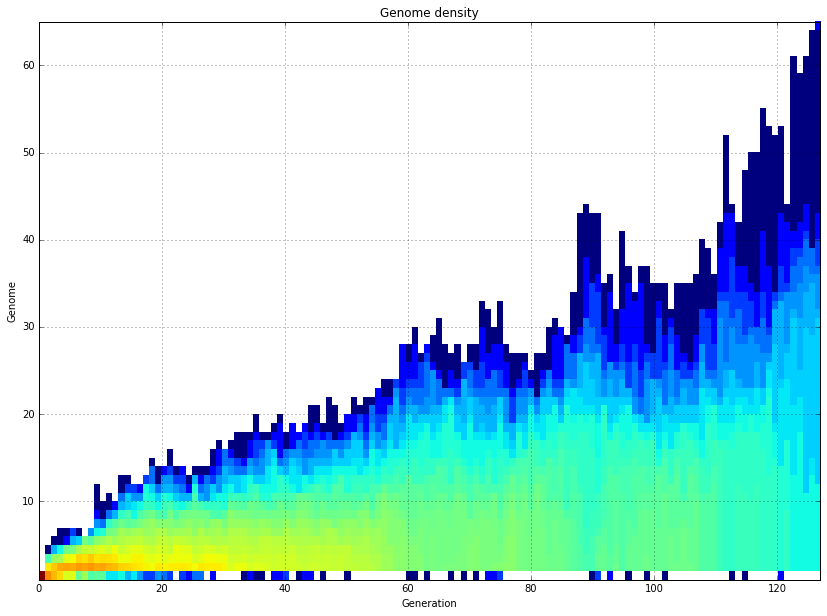

In [5]:
# What genomes are used over time
from matplotlib import colors
fig, ax = plt.subplots()
plt.hist2d(df['gen'], df['genome'], bins=(128, 64), cmin=1, norm=colors.LogNorm())
ax.set_title('Genome density')
ax.set_xlabel('Generation')
ax.set_ylabel('Genome')
plt.grid()
plt.show()

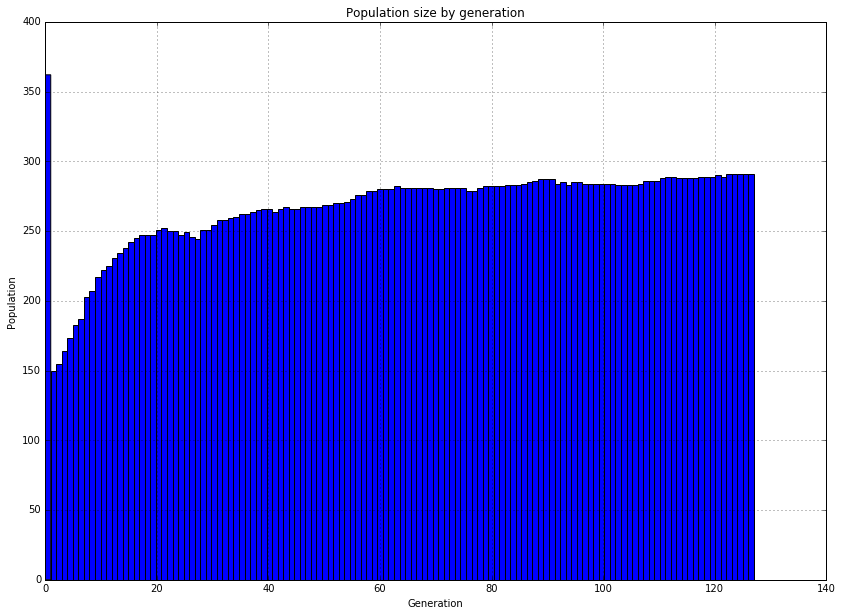

In [6]:
# Population size by generation
fig, ax = plt.subplots()
plt.hist(df['gen'], bins=len(set(all_gen)))
ax.set_title('Population size by generation')
ax.set_xlabel('Generation')
ax.set_ylabel('Population')
plt.grid()
plt.show()

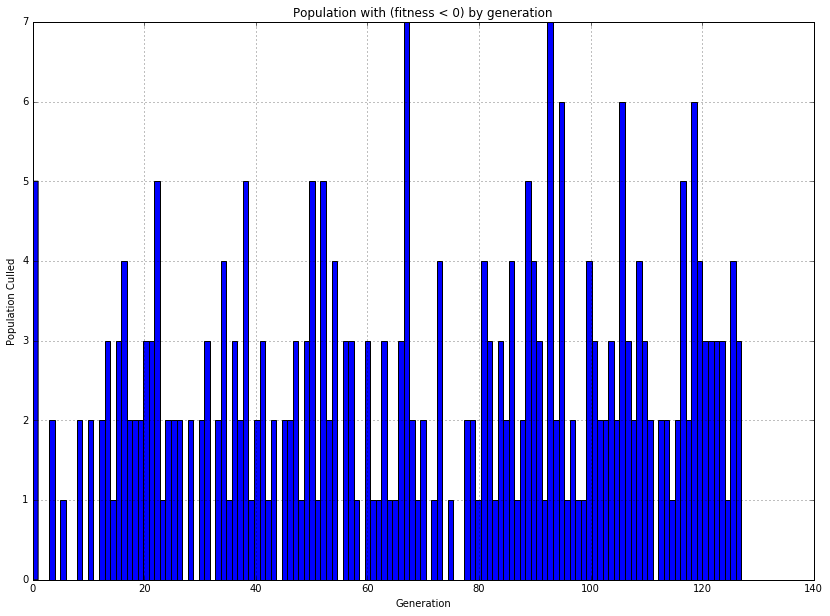

In [7]:
# Population with negarive fitness, by generation
fig, ax = plt.subplots()
plt.hist(df.query('fitness < 0')['gen'], bins=len(set(all_gen)))
ax.set_title('Population with (fitness < 0) by generation')
ax.set_xlabel('Generation')
ax.set_ylabel('Population Culled')
plt.grid()
plt.show()